# Librerias

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Datos

[MNIST dataset](http://yann.lecun.com/exdb/mnist/)

In [ ]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

print(train_data)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.43MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.86MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dimensiones de la imagen:  torch.Size([28, 28])


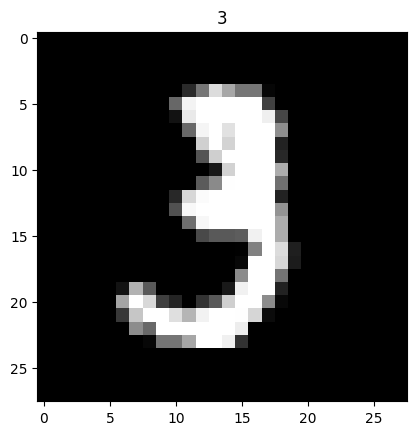

In [ ]:
print('Dimensiones de la imagen: ', train_data.data[1].shape)

plt.imshow(train_data.data[10], cmap = 'gray')
plt.title('%i' % train_data.targets[10])
plt.show()

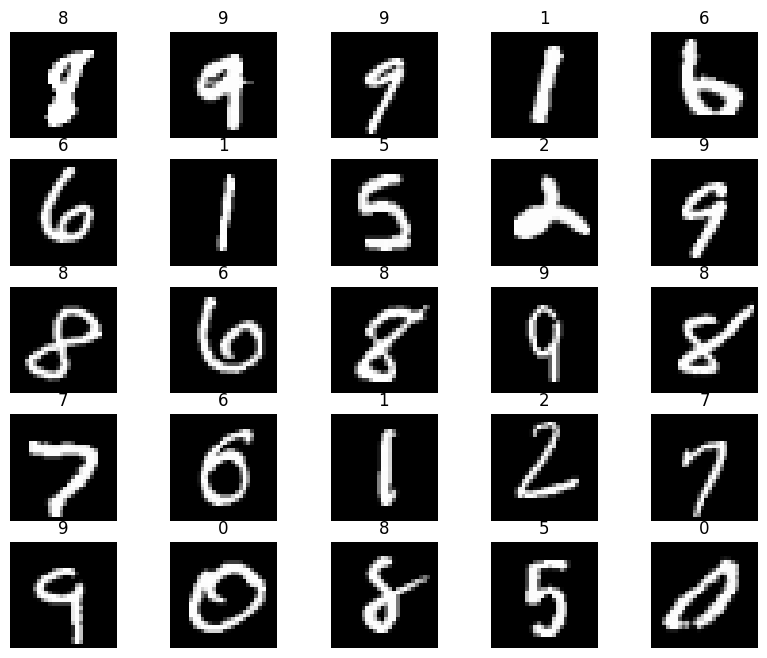

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows +1):
  sample_idx = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, i)

  plt.title(label)
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')

plt.show()

# Modelo

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)

        self.pool2 = nn.MaxPool2d(2)

        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1) # Aplanar la salida de la segunda capa de agrupación para alimentar la capa completamente conectada

        x = self.fc(x)

        return x

## Cargar el modelo

In [ ]:
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

# Función de perdida y de optimización

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)
print('Optimizer: ', optimizer)

Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


# División de datos en conjuntos de entrenamiento y validación

In [ ]:
train_size = int(0.8 * len(train_data))

train_set, val_set = torch.utils.data.random_split(train_data, [train_size, len(train_data) - train_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)

# Entrenamiento

In [ ]:
num_epochs = 4
all_losses = []

cnn.train()
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        output = cnn(inputs)
        loss = loss_function(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print('Epoca [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    epoch_loss = running_loss / len(train_loader)
    all_losses.append(epoch_loss)
    print(f'Epoca [{epoch + 1}/{num_epochs}], Promedio de perdida: {epoch_loss:.4f}')
print('Entrenamiento finalizado')


Epoca [1/4], Step [100/480], Loss: 0.1377
Epoca [1/4], Step [200/480], Loss: 0.0682
Epoca [1/4], Step [300/480], Loss: 0.1135
Epoca [1/4], Step [400/480], Loss: 0.1635
Epoca [1/4], Promedio de perdida: 0.2653
Epoca [2/4], Step [100/480], Loss: 0.0501
Epoca [2/4], Step [200/480], Loss: 0.0212
Epoca [2/4], Step [300/480], Loss: 0.0448
Epoca [2/4], Step [400/480], Loss: 0.0338
Epoca [2/4], Promedio de perdida: 0.0834
Epoca [3/4], Step [100/480], Loss: 0.1192
Epoca [3/4], Step [200/480], Loss: 0.0579
Epoca [3/4], Step [300/480], Loss: 0.0491
Epoca [3/4], Step [400/480], Loss: 0.0984
Epoca [3/4], Promedio de perdida: 0.0696
Epoca [4/4], Step [100/480], Loss: 0.0598
Epoca [4/4], Step [200/480], Loss: 0.0141
Epoca [4/4], Step [300/480], Loss: 0.0461
Epoca [4/4], Step [400/480], Loss: 0.0146
Epoca [4/4], Promedio de perdida: 0.0640
Entrenamiento finalizado


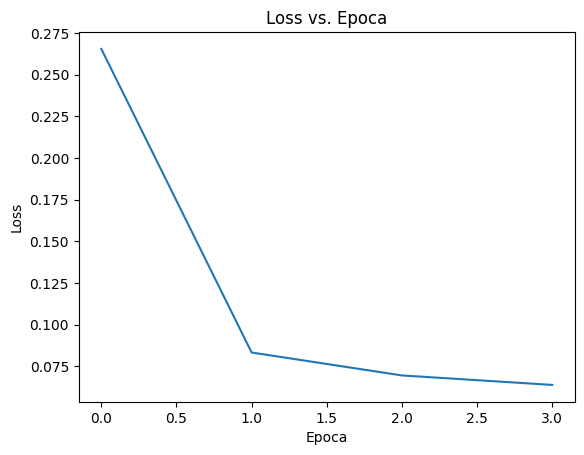

In [ ]:
plt.plot(all_losses)
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Loss vs. Epoca')
plt.show()

# Evaluación

In [ ]:
correct = 0
total = 0

cnn.eval()
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Precisión en el conjunto de validación.: {100 * correct / total:.2f}%')

Precisión en el conjunto de validación.: 97.87%


In [ ]:
sample = next(iter(val_loader))
images, labels = data
actual_number = labels[:10].numpy()
print(actual_number)

[7 1 6 2 0 1 4 4 9 1]


In [ ]:
test_output = cnn(images[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Clase real: {actual_number}')
print(f'Predicción: {pred_y}')

Clase real: [7 1 6 2 0 1 4 4 9 1]
Predicción: [7 1 6 2 0 1 4 4 9 1]


In [ ]:
images[0].shape

torch.Size([1, 28, 28])

In [ ]:
actual_number

array([7, 1, 6, 2, 0, 1, 4, 4, 9, 1])

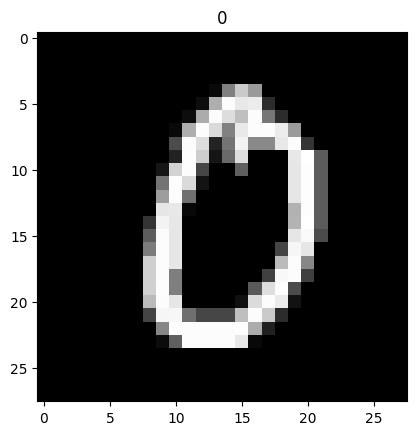

In [ ]:
id = 4
img = images[id].permute(1, 2, 0)
plt.imshow(img, cmap = 'gray')
plt.title('%i' % actual_number[id])
plt.show()